<a href="https://colab.research.google.com/github/wakamatsuikuma/scratch-deeplearning/blob/main/Ch5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# coding: utf-8

import sys, os
ｓys.path.append("/content/drive/MyDrive/ゼロからつくるディープラーニング")
ｓys.path.append("/content/drive/MyDrive/ゼロからつくるディープラーニング/dataset")
ｓys.path.append("/content/drive/MyDrive/ゼロからつくるディープラーニング/common")
ｓys.path.append("/content/drive/MyDrive/ゼロからつくるディープラーニング/Ch4")

import numpy as np
from mnist import load_mnist
from PIL import Image
from IPython.display import display
import pickle
from functions import sigmoid, softmax
from two_layer_net import TwoLayerNet


# グーグルコラボなので画像表示はこれ使う
def img_show(img):
    pil_img = Image.fromarray(np.uint8(img))
    display(pil_img)

# ファイルをアップロード
from google.colab import files
uploaded = files.upload()

In [ ]:
"""
乗算レイヤの実装
 順伝播と逆伝播のメソッドを実装
"""

class MulLayer:
  # ｘ、ｙの初期化。順伝播時の入力値を保持するため。
  def __init__(self):
    self.x = None
    self.y = None
  
  def forward(self, x, y):
    self.x = x
    self.y = y
    out = self.x * self.y

    return out
  
  # 微分(dout)に対して"ひっくり返した値"をかけて流す
  def backward(self, dout):
    dx = dout * self.y
    dy = dout * self.x

    return dx, dy

    

In [ ]:
"""
りんご2個の買い物　を実装
"""

# 入力は単価、個数、消費税
apple = 100
apple_num = 2
tax = 1.1


# 各レイヤのインスタンス生成
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()


# 価格(順伝播)の計算
apple_price = mul_apple_layer.forward(apple, apple_num)
total_price = mul_tax_layer.forward(apple_price, tax)

print(apple_price, total_price)


# 各レイヤの微分(呼び出す順番は順伝播の逆)
dtotal_price = 1

dapple_price, dtax = mul_tax_layer.backward(dtotal_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple, dapple_num, dtax)

200 220.00000000000003
2.2 110.00000000000001 200


In [ ]:
"""
加算レイヤの実装
"""

class AddLayer:
  # インスタンス生成。保持する必要のある値は無い。
  def __init__(self):
    pass
  
  # 順伝播
  def forward(self, x, y):
    out = x + y

    return out

  # 逆伝播
  def backward(self, dout):
    dx = dout * 1
    dy = dout * 1
    
    return dx, dy


In [ ]:
"""
りんご2個とみかん3個の買い物
"""
# 入力値
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# 各レイヤのインスタンス生成
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()


# 価格を計算 = 順伝播
apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
add_price = add_apple_orange_layer.forward(apple_price, orange_price)
total_price = mul_tax_layer.forward(add_price, tax)

print(apple_price, orange_price, add_price, total_price)


# 各入力の微分を計算 = 逆伝播
dtotal_price = 1

dadd_price, dtax = mul_tax_layer.backward(dtotal_price)
dapple_price, dorange_price = add_apple_orange_layer.backward(dadd_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print("total_price:", int(total_price))
print("dApple:", dapple)
print("dApple_num:", int(dapple_num))
print("dOrange:", dorange)
print("dOrange_num:", int(dorange_num))
print("dTax:", dtax)


200 450 650 715.0000000000001
total_price: 715
dApple: 2.2
dApple_num: 110
dOrange: 3.3000000000000003
dOrange_num: 165
dTax: 650


In [ ]:
"""
ReLuレイヤの実装
"""

class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx


In [ ]:
"""
sigmoidレイヤの実装
"""
import numpy as np

class Sigmoid:
  
  def __init__(self):
    self.out = None

  def forward(self, x):
    out = 1 / (1 + np.exp(-x))
    self.out = out # 逆伝播時に使うので、インスタンス変数に保持

    return out
  
  def backward(self, dout):
    dx = dout * sef.out * (1.0 - self.out)

    return dx


In [ ]:
"""
Affine変換の実装
"""
import numpy as np

class Affine:
  def __init__(self, W, b):
    self.W = W
    self.b = b
    self.x = None
    self.original_x_shape = None # テンソル対応のため形状を保持

    self.dw = None
    self.db = None

  def forward(self, x):
    self.original_x_shape = x.shape
    x = x.reshape(x.shape[0], -1)
    self.x = x
    out = np.dot(self.x, self.w) + self.b
    
    return out


  def backward(self, dout):
    dx = np.dot(dout, self.W.T)
    dx = dx.reshape(*self.original_x_shape) # 入力データの形状に戻す(テンソル対応)

    self.dW = np.dot(self.x.T, dout)
    self.db = np.sum(dout, axis=0)

    return dx
    

In [ ]:
"""
損失関数も含めたsoftmaxレイヤ(出力層)の実装
  = softmax-with-lossレイヤ
"""


class SoftmaxWithLoss:
  def __init__(self):
    self.loss = None # 損失
    self.y = None # softmaxの出力
    self.t = None # 正解ラベル(one-hot vector)
    

  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.t)

    return self.loss

  def backward(self, dout=1):
    batch_size = self.t.shape[0]
    dx = (self.y - self.t) * (dout / batch_size) # 一つのデータを学習データ数で予測しているという意味だからか？

    return dx




In [12]:
"""
誤差逆伝播法に対応した学習アルゴリズムの実装
　　　　　2層NNのクラス
   クラスの中身=勾配計算：2層となるようにパラメーター設定→推論値計算→損失関数計算→勾配計算
"""

import numpy as np
from functions import *
from gradient import numerical_gradient
from collections import OrderedDict

class TwoLayerNet:
  # 引数は入力層のニューロン数、隠れ層のニューロン数、出力層のニューロン数
  def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
    # 辞書型で格納していく。また重みはガウス分布による乱数生成で初期化。バイアスは0で初期化。
    self.params = {}
    self.params["W1"] = weight_init_std * np.random.randn(input_size, hidden_size)
    self.params["b1"] = np.zeros(hidden_size)
    self.params["W2"] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params["b2"] = np.zeros(output_size)

    # レイヤの生成
    self.layers = OrderedDict() #  順番付きディクショナリ。追加した順番のレイヤで処理ができる。
    
    self.layers["Affine1"] = Affine(self.params["W1"], self.params["b1"]) # 第1層目の信号伝達
    self.layers["ReLu1"] = Relu() # 第1層目の活性化関数
    self.layers["Affine2"] = Affine(self.params["W2"], self.params["b2"]) # 第2層の信号伝達
    
    self.lastLayer = SoftmaxWithLoss()


  # 認識(推論)を行う。モジュール化されたレイヤ呼び出しで簡潔に。
  def predict(self, x):
    for layer in self.layers.values():
      y = layer.forward(x)

    return y


  # 損失関数。xが入力、tが正解ラベル
  def loss(self, x, t):
    y = self.predict(x)
    return self.lastLayer.forward(y, t)
  
  # 精度計算
  def accuracy(self, x, t):
    y = self.predict(x)
    y = np.argmax(y, axis=1)
    if t.ndim != 1 : t = np.argmax(t, axis=1)
        
    accuracy = np.sum(y == t) / float(x.shape[0])
    return accuracy

  # 勾配計算。xが入力、tが正解ラベル
  def numerical_gradient(self, x, t):
    W1, W2 = self.params["W1"], self.params["W2"]
    b1, b2 = self.params["b1"], self.params["b2"]

    loss_W = lambda W: self.loss(x, t) # ここ関数にする必要ある？

    # 各パラメータ行列毎の勾配求めるのに、各パラメータによる最終出力値から計算される損失関数の値を使うイメージがつかない。
    # 偏微分の偏微分みたいな？
    grads = {}
    grads["W1"] = numerical_gradient(loss_W, W1)
    grads["b1"] = numerical_gradient(loss_W, b1)
    grads["W2"] = numerical_gradient(loss_W, W2)
    grads["b2"] = numerical_gradient(loss_W, b2)


  def gradient(self, x, t):

    # 順伝播
    self.loss(x, t)

    # 逆伝播
    dout = self.lastLayer.backward() # 2層目の信号伝達の微分値

    layers = list(self.lastLayer.values())
    layers.reserve() # 順伝播のためにリストをディクショナリーを逆にする。
    for layer in layers:
      dout = layer.backward(dout) # 逆伝播を計算。各微分値は保持されている。

    grads = {}
    grads["W1"] = self.layers["Affine1"].dW
    grads["b1"] = self.layers["Affine1"].db
    grads["W2"] = self.layers["Affine2"].dW
    grads["b2"] = self.layers["Affine2"].db

    return grads



In [16]:
import numpy as np
from mnist import load_mnist
from two_layer_net import TwoLayerNet

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

# ネットワーク定義
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# バッチ抽出。確認だけなので、データサイズは小さめ。
x_batch = x_train[:3]
t_batch = t_train[:3]

# 数値的および誤差逆伝播による微分値計算
grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

# 微分値の絶対誤差を計算
for key in grad_numerical.keys():
  diff = np.average(np.abs(grad_numerical[key] - grad_backprop[key]))
  print(key + ":" + str(diff))

W1:1.8091664504856096e-10
b1:9.981800022120217e-10
W2:6.974174648631537e-08
b2:1.38524412804375e-07


train acc, test acc | 0.10441666666666667, 0.1028
train acc, test acc | 0.7852166666666667, 0.7931
train acc, test acc | 0.8754666666666666, 0.8798
train acc, test acc | 0.89775, 0.899
train acc, test acc | 0.90745, 0.9099
train acc, test acc | 0.9135333333333333, 0.9139
train acc, test acc | 0.9192833333333333, 0.9206
train acc, test acc | 0.9236833333333333, 0.9255
train acc, test acc | 0.9277166666666666, 0.9291
train acc, test acc | 0.9303666666666667, 0.931
train acc, test acc | 0.9335333333333333, 0.9341
train acc, test acc | 0.9367, 0.9375
train acc, test acc | 0.9389166666666666, 0.9388
train acc, test acc | 0.9407, 0.9384
train acc, test acc | 0.9429333333333333, 0.9413
train acc, test acc | 0.9450833333333334, 0.9418
train acc, test acc | 0.9467666666666666, 0.9433


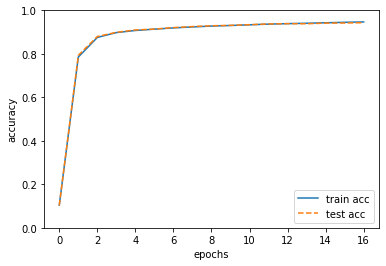

In [18]:
"""
ミニバッチ学習の実装/テストデータに対する精度を1エポックごとに計算し描画
"""

import numpy as np
from mnist import load_mnist
from two_layer_net import TwoLayerNet

# データの取得
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)


# ニューラルネットワークのインスタンス生成
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)


# ハイパーパラメーター設定
iters_num = 10000  # 更新回数
learning_rate = 0.1  # 学習率
batch_size = 100 # バッチサイズ


train_loss_list = [] # 損失関数の値を1更新ごとに入れていく
train_size = x_train.shape[0]
test_acc_list = []
train_acc_list = []
iters_per_epoch = max(train_size / batch_size, 1)# 1エポックあたりの繰り返し数


# ミニバッチ学習：ミニバッチの取得→勾配計算→パラメーター更新　を繰り返す
# ミニバッチサイズ100で一回更新ごとにデータ変えてるのが不思議な感じ
for i in range(iters_num):

  # ミニバッチでデータ取得
  batch_mask = np.random.choice(train_size, batch_size, replace=False)
  x_batch = x_train[batch_mask]
  t_batch = t_train[batch_mask]

  # 勾配計算
  # grad = network.numerical_gradient(x_batch, t_batch)
  grad = network.gradient(x_batch, t_batch) # 高速版
  
  # パラメーター更新(=学習)
  for key in ("W1", "b1", "W2", "b2"):
    network.params[key] -= learning_rate * grad[key]

  # 学習結果の記録
  train_loss_list.append(network.loss(x_batch, t_batch))

  # 1エポックごとに認識精度計算
  if i % iters_per_epoch == 0:
    train_acc = network.accuracy(x_train, t_train)
    test_acc = network.accuracy(x_test, t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))


# グラフの描画
import matplotlib.pyplot as plt
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()